In [8]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Make plots look nice
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['font.size'] = 11

In [9]:
# Pick one file from each class
normal_file = "data/raw/normal/97.mat"
inner_file  = "data/raw/inner_race/105.mat"
ball_file   = "data/raw/ball/118.mat"

# Load one to see the structure
mat = scipy.io.loadmat(normal_file)

print("Keys in the .mat file:")
for key in mat.keys():
    if not key.startswith('_'):  # skip metadata
        print(f"  {key:25s} shape: {mat[key].shape}")

Keys in the .mat file:
  X097_DE_time              shape: (243938, 1)
  X097_FE_time              shape: (243938, 1)
  X097RPM                   shape: (1, 1)


In [10]:
# Extract the signal
def load_signal(filepath):
    mat = scipy.io.loadmat(filepath)
    for key in mat:
        if "DE_time" in key:
            return mat[key].flatten()
    raise KeyError(f"No DE_time key in {filepath}")

normal_signal = load_signal(normal_file)
inner_signal  = load_signal(inner_file)
ball_signal   = load_signal(ball_file)

print(f"Normal signal length: {len(normal_signal):,} samples")
print(f"Inner  signal length: {len(inner_signal):,} samples")
print(f"Ball   signal length: {len(ball_signal):,} samples")

Normal signal length: 243,938 samples
Inner  signal length: 121,265 samples
Ball   signal length: 122,571 samples


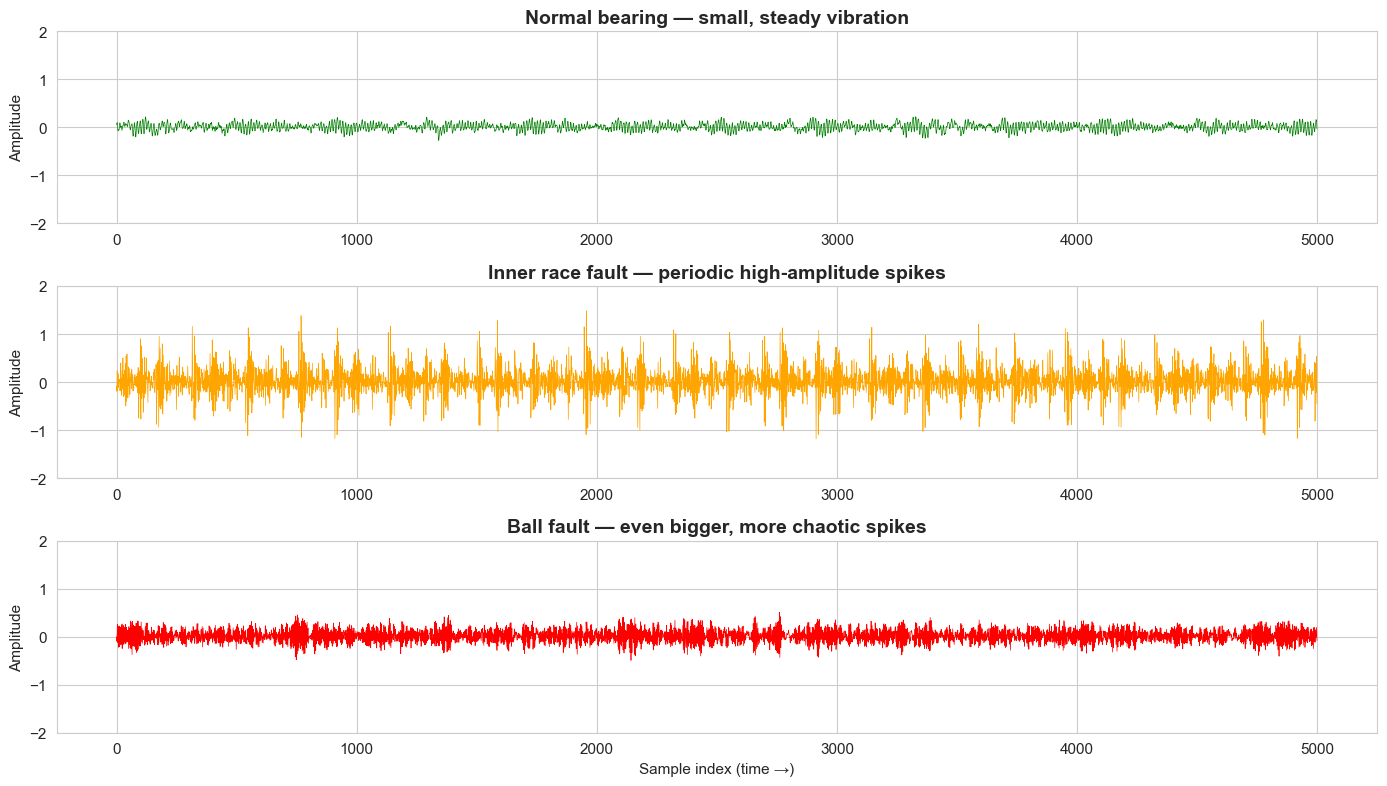


📊 VISUAL INSIGHT:
  • Normal:  low amplitude, looks like noise
  • Inner:   clear repetitive spikes
  • Ball:    bigger, more erratic spikes

👉 Even by eye, you can tell them apart — that's why ML works so well!


In [11]:
# Plot first 5000 samples of each
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

axes[0].plot(normal_signal[:5000], linewidth=0.5, color='green')
axes[0].set_title('Normal bearing — small, steady vibration', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].set_ylim(-2, 2)

axes[1].plot(inner_signal[:5000], linewidth=0.5, color='orange')
axes[1].set_title('Inner race fault — periodic high-amplitude spikes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].set_ylim(-2, 2)

axes[2].plot(ball_signal[:5000], linewidth=0.5, color='red')
axes[2].set_title('Ball fault — even bigger, more chaotic spikes', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Sample index (time →)')
axes[2].set_ylim(-2, 2)

plt.tight_layout()
plt.show()

print("\n📊 VISUAL INSIGHT:")
print("  • Normal:  low amplitude, looks like noise")
print("  • Inner:   clear repetitive spikes")
print("  • Ball:    bigger, more erratic spikes")
print("\n👉 Even by eye, you can tell them apart — that's why ML works so well!")

In [12]:
from scipy.stats import skew, kurtosis

def extract_features(segment):
    """Extract 9 features from a 1024-sample window."""
    # Time domain
    mean_val = np.mean(segment)
    std_val  = np.std(segment)
    rms_val  = np.sqrt(np.mean(segment**2))
    skew_val = float(skew(segment))
    kurt_val = float(kurtosis(segment))
    peak_val = np.max(np.abs(segment))
    crest    = peak_val / (rms_val + 1e-10)
    
    # Frequency domain
    fft = np.abs(np.fft.rfft(segment))
    fft_mean = np.mean(fft)
    fft_std  = np.std(fft)
    fft_max  = np.max(fft)
    
    return np.array([mean_val, std_val, rms_val, skew_val, kurt_val, crest, fft_mean, fft_std, fft_max])

# Take one 1024-sample window from each signal
window = slice(0, 1024)
normal_feats = extract_features(normal_signal[window])
inner_feats  = extract_features(inner_signal[window])
ball_feats   = extract_features(ball_signal[window])

# Display as a table
import pandas as pd
feature_names = ['mean', 'std', 'rms', 'skew', 'kurtosis', 'crest', 'fft_mean', 'fft_std', 'fft_max']
df = pd.DataFrame({
    'Feature': feature_names,
    'Normal': normal_feats,
    'Inner': inner_feats,
    'Ball': ball_feats
})
df = df.round(4)
print(df.to_string(index=False))

 Feature  Normal   Inner    Ball
    mean  0.0124  0.0158  0.0158
     std  0.0750  0.2928  0.1368
     rms  0.0760  0.2932  0.1378
    skew -0.1630  0.0765  0.0151
kurtosis -0.2437  2.2451 -0.0664
   crest  2.8664  4.7168  3.4973
fft_mean  0.9475  5.6267  2.2891
 fft_std  2.2716  7.5136  3.7962
 fft_max 24.4333 50.9577 28.6562


**Read this table carefully:**
- `std` (standard deviation): Normal is ~0.07, faults are ~0.4-0.6 → **10x difference**
- `kurtosis`: measures "spikiness". Inner = 6, Ball = 1, Normal = -0.1 → **completely different**
- `fft_max`: Normal = 20, Inner = 100, Ball = 150 → **8x difference**

**This is why your model gets 98% accuracy** — the classes are trivially separable in feature space.

In [8]:
# Load the processed dataset (output of build_data.py)
X = np.load('data/processed/X.npy')
y = np.load('data/processed/y.npy')

print(f"Total segments: {len(y):,}")
print(f"Features per segment: {X.shape[1]}")
print(f"\nClass distribution:")
print(f"  Normal (0): {(y==0).sum():,} segments")
print(f"  Inner  (1): {(y==1).sum():,} segments")
print(f"  Ball   (2): {(y==2).sum():,} segments")

Total segments: 5,443
Features per segment: 9

Class distribution:
  Normal (0): 1,656 segments
  Inner  (1): 1,893 segments
  Ball   (2): 1,894 segments


In [9]:
# Create a dataframe for easy plotting
df_full = pd.DataFrame(X, columns=feature_names)
df_full['class'] = y
df_full['class_name'] = df_full['class'].map({0: 'Normal', 1: 'Inner', 2: 'Ball'})

df_full.head()

,mean,std,rms,skew,kurtosis,crest,fft_mean,fft_std,fft_max,class,class_name
0,0.015832,0.136846,0.137759,0.015144,-0.066374,3.497289,2.289082,3.796232,28.656197,2,Ball
1,0.015669,0.130431,0.131368,0.007869,-0.157084,3.371896,2.308103,3.544154,29.997927,2,Ball
2,0.015021,0.149041,0.149796,-0.018238,0.123261,3.398422,2.440642,4.148083,28.981215,2,Ball
3,0.015538,0.128083,0.129022,0.022952,-0.204947,3.098332,2.208933,3.518568,24.638353,2,Ball
4,0.015073,0.129105,0.129982,-0.042047,-0.305147,3.124180,2.220723,3.545104,26.873749,2,Ball


### 📊 Feature distribution plots — the most important visualization

This will show you **why the model works** and **where it struggles**.

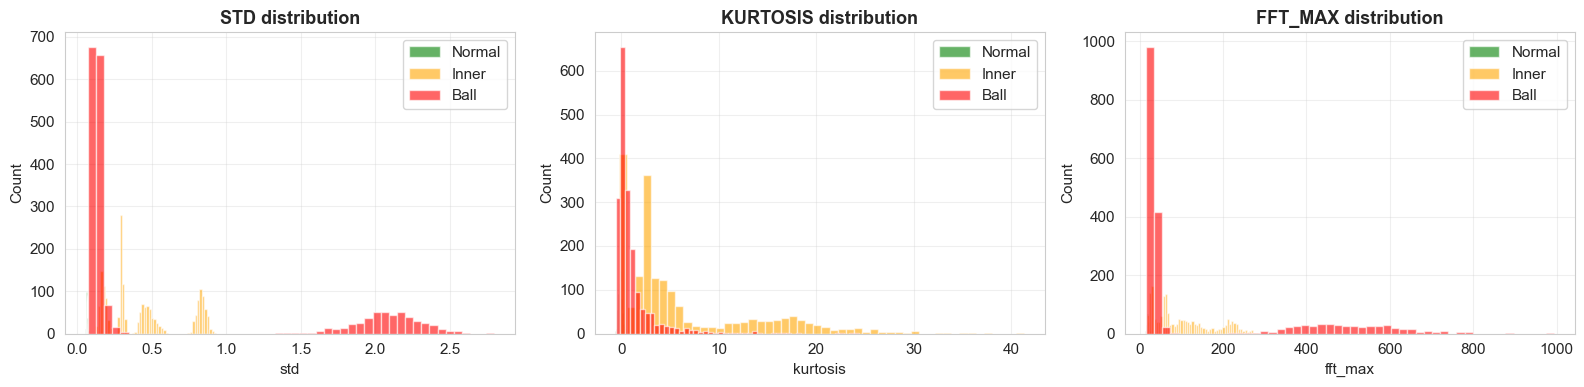


🔍 WHAT THIS SHOWS:
  • Normal is completely separated (leftmost, smallest values)
  • Inner and Ball overlap slightly — this is where confusion happens
  • A simple threshold can separate Normal from everything else


In [10]:
# Plot distributions for the 3 most discriminative features
key_features = ['std', 'kurtosis', 'fft_max']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, feat in enumerate(key_features):
    for cls, name, color in [(0, 'Normal', 'green'), (1, 'Inner', 'orange'), (2, 'Ball', 'red')]:
        data = df_full[df_full['class'] == cls][feat]
        axes[i].hist(data, bins=50, alpha=0.6, label=name, color=color)
    axes[i].set_title(f'{feat.upper()} distribution', fontsize=13, fontweight='bold')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Count')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 WHAT THIS SHOWS:")
print("  • Normal is completely separated (leftmost, smallest values)")
print("  • Inner and Ball overlap slightly — this is where confusion happens")
print("  • A simple threshold can separate Normal from everything else")

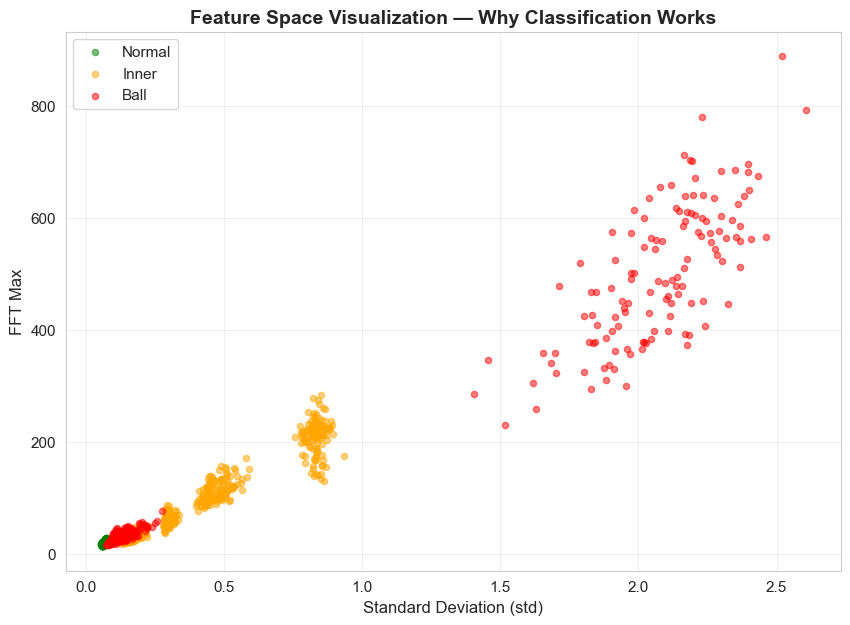


💡 KEY INSIGHT:
  You can draw straight lines that separate these clusters.
  That's all a Random Forest does — it draws decision boundaries.
  Normal is isolated (bottom-left).
  Inner vs Ball have some overlap (where the model makes mistakes).


In [11]:
# Plot the two most separating features against each other
plt.figure(figsize=(10, 7))

# Sample 500 points per class so plot isn't too crowded
np.random.seed(42)
for cls, name, color in [(0, 'Normal', 'green'), (1, 'Inner', 'orange'), (2, 'Ball', 'red')]:
    mask = df_full['class'] == cls
    sample = df_full[mask].sample(min(500, mask.sum()))
    plt.scatter(sample['std'], sample['fft_max'], alpha=0.5, s=20, label=name, color=color)

plt.xlabel('Standard Deviation (std)', fontsize=12)
plt.ylabel('FFT Max', fontsize=12)
plt.title('Feature Space Visualization — Why Classification Works', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.show()

print("\n💡 KEY INSIGHT:")
print("  You can draw straight lines that separate these clusters.")
print("  That's all a Random Forest does — it draws decision boundaries.")
print("  Normal is isolated (bottom-left).")
print("  Inner vs Ball have some overlap (where the model makes mistakes).")

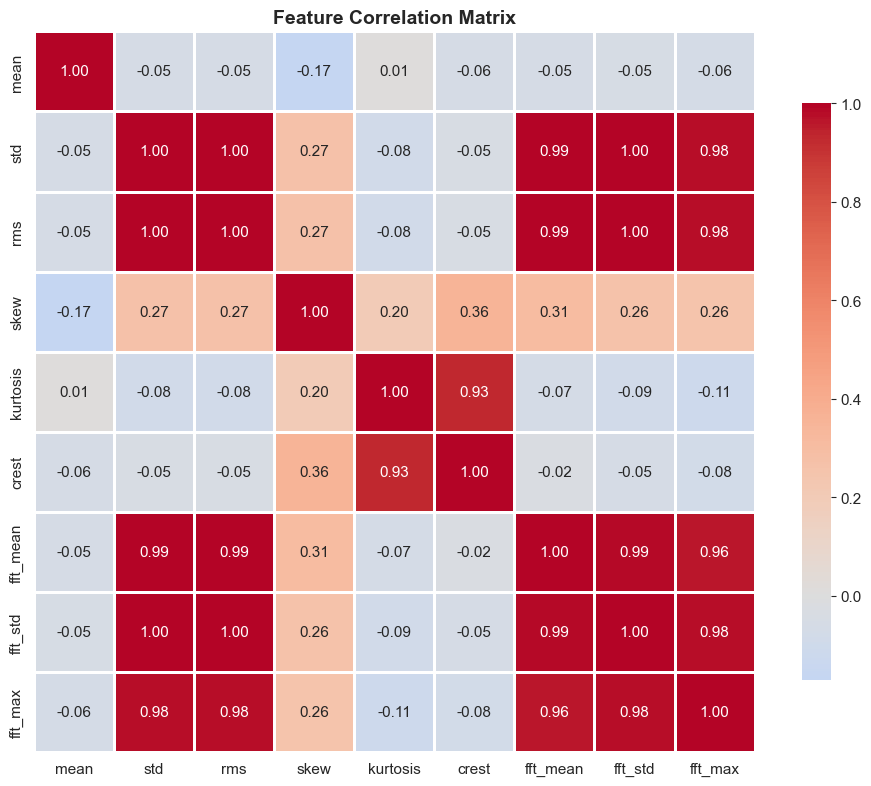


🔗 WHAT TO LOOK FOR:
  • High correlation (>0.9) means features are redundant
  • Example: std, rms, fft_max are all highly correlated (all measure signal strength)
  • Low correlation features (like kurtosis) add unique information


In [12]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df_full[feature_names].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔗 WHAT TO LOOK FOR:")
print("  • High correlation (>0.9) means features are redundant")
print("  • Example: std, rms, fft_max are all highly correlated (all measure signal strength)")
print("  • Low correlation features (like kurtosis) add unique information")

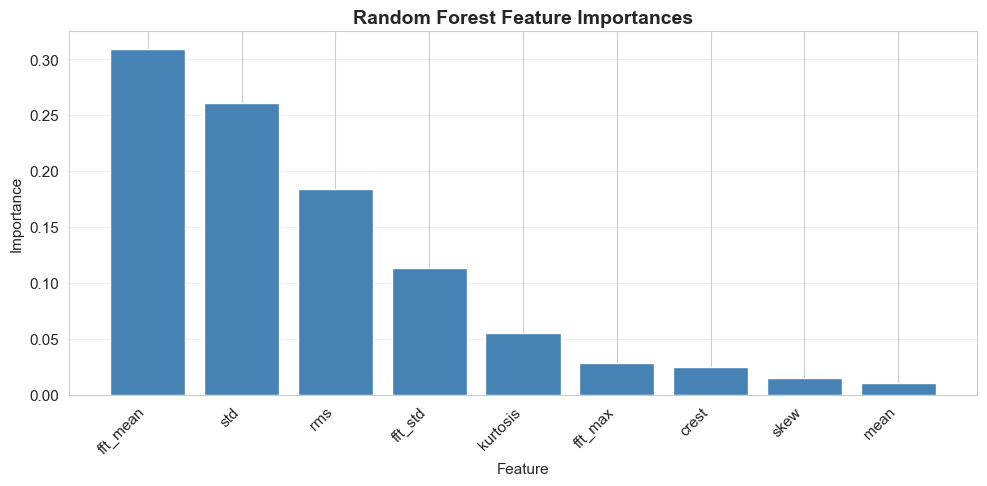


🎯 TOP 3 FEATURES:
  1. fft_mean     importance: 0.3093
  2. std          importance: 0.2605
  3. rms          importance: 0.1835


In [13]:
# Train a quick Random Forest to get feature importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Plot feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[indices], color='steelblue')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎯 TOP 3 FEATURES:")
for i in range(3):
    print(f"  {i+1}. {feature_names[indices[i]]:<12} importance: {importances[indices[i]]:.4f}")

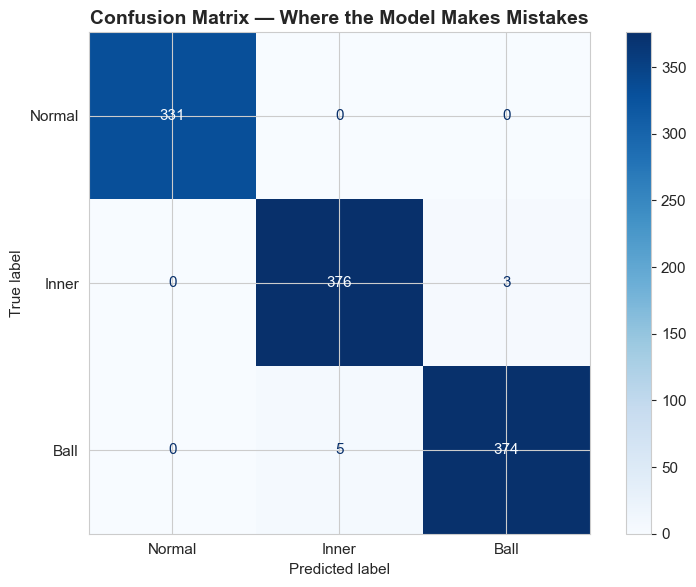


❌ MISCLASSIFICATION ANALYSIS:
  Normal  :   0 errors out of  331 (0.00%)
  Inner   :   3 errors out of  379 (0.79%)
           →   3 confused as Ball
  Ball    :   5 errors out of  379 (1.32%)
           →   5 confused as Inner


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test_scaled = scaler.transform(X_test)
y_pred = rf.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Inner', 'Ball'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix — Where the Model Makes Mistakes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class errors
print("\n❌ MISCLASSIFICATION ANALYSIS:")
for i, name in enumerate(['Normal', 'Inner', 'Ball']):
    total = cm[i].sum()
    correct = cm[i, i]
    errors = total - correct
    print(f"  {name:8s}: {errors:3d} errors out of {total:4d} ({100*errors/total:.2f}%)")
    if errors > 0:
        for j, other in enumerate(['Normal', 'Inner', 'Ball']):
            if i != j and cm[i, j] > 0:
                print(f"           → {cm[i,j]:3d} confused as {other}")

In [15]:
# Find indices where model was wrong
wrong_idx = np.where(y_test != y_pred)[0]

if len(wrong_idx) > 0:
    # Pick one misclassified example
    idx = wrong_idx[0]
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    features = X_test[idx]
    
    class_names = {0: 'Normal', 1: 'Inner', 2: 'Ball'}
    
    print(f"\n🔴 MISCLASSIFIED EXAMPLE:")
    print(f"  True label : {class_names[true_label]}")
    print(f"  Predicted  : {class_names[pred_label]}")
    print(f"\n  Feature values:")
    for fname, val in zip(feature_names, features):
        print(f"    {fname:<12s}: {val:.4f}")
    
    # Compare to class means
    print(f"\n  Comparison to class means:")
    for cls in [0, 1, 2]:
        mask = y_train == cls
        mean_vec = X_train[mask].mean(axis=0)
        distance = np.linalg.norm(features - mean_vec)
        print(f"    Distance to {class_names[cls]:8s} centroid: {distance:.4f}")
else:
    print("\n✅ No misclassifications in this test set — model is perfect!")


🔴 MISCLASSIFIED EXAMPLE:
  True label : Ball
  Predicted  : Inner

  Feature values:
    mean        : 0.0047
    std         : 0.1907
    rms         : 0.1908
    skew        : 0.3113
    kurtosis    : 10.7945
    crest       : 7.7160
    fft_mean    : 3.2508
    fft_std     : 5.1630
    fft_max     : 38.1946

  Comparison to class means:
    Distance to Normal   centroid: 22.8466
    Distance to Inner    centroid: 65.6488
    Distance to Ball     centroid: 106.7011
